In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

import os

os.makedirs("imgs", exist_ok=True)


In [24]:
# Load datasets
daily_activity = pd.read_csv('dataset/dailyActivity_merged.csv')
daily_calories = pd.read_csv('dataset/dailyCalories_merged.csv')
daily_steps = pd.read_csv('dataset/dailySteps_merged.csv')

hourly_steps = pd.read_csv('dataset/hourlySteps_merged.csv')
hourly_calories = pd.read_csv('dataset/hourlyCalories_merged.csv')

sleep_data = pd.read_csv('dataset/sleepDay_merged.csv')

minute_sleep = pd.read_csv('dataset/minuteSleep_merged.csv')

In [25]:
daily_activity.shape

(940, 15)

In [26]:
daily_calories.shape

(940, 3)

In [27]:
daily_steps.shape

(940, 3)

In [28]:
hourly_steps.shape

(22099, 3)

In [29]:
hourly_calories.shape

(22099, 3)

In [30]:
sleep_data.shape

(413, 5)

In [31]:
minute_sleep.shape

(188521, 4)

In [32]:
# Data Cleaning
def clean_data(df):
    #missing values
    df = df.dropna()
    
    #outliers
    numeric_cols = df.select_dtypes(include=['number']).columns
    df = df[~((df[numeric_cols] - df[numeric_cols].mean()).abs() > 3 * df[numeric_cols].std()).any(axis=1)]
    
    return df

In [33]:
daily_activity_cleaned = clean_data(daily_activity)
daily_calories_cleaned = clean_data(daily_calories)
daily_steps_cleaned = clean_data(daily_steps)

hourly_steps_cleaned = clean_data(hourly_steps)
hourly_calories_cleaned = clean_data(hourly_calories)

sleep_data_cleaned = clean_data(sleep_data)

minute_sleep_cleaned = clean_data(minute_sleep)

In [34]:
daily_activity_cleaned.shape

(829, 15)

In [35]:
daily_calories_cleaned.shape

(928, 3)

In [36]:
daily_steps_cleaned.shape

(934, 3)

In [37]:
hourly_steps_cleaned.shape

(21586, 3)

In [38]:
hourly_calories_cleaned.shape

(21650, 3)

In [39]:
sleep_data_cleaned.shape

(399, 5)

In [40]:
minute_sleep_cleaned.shape

(186503, 4)

# Group-Level Observations

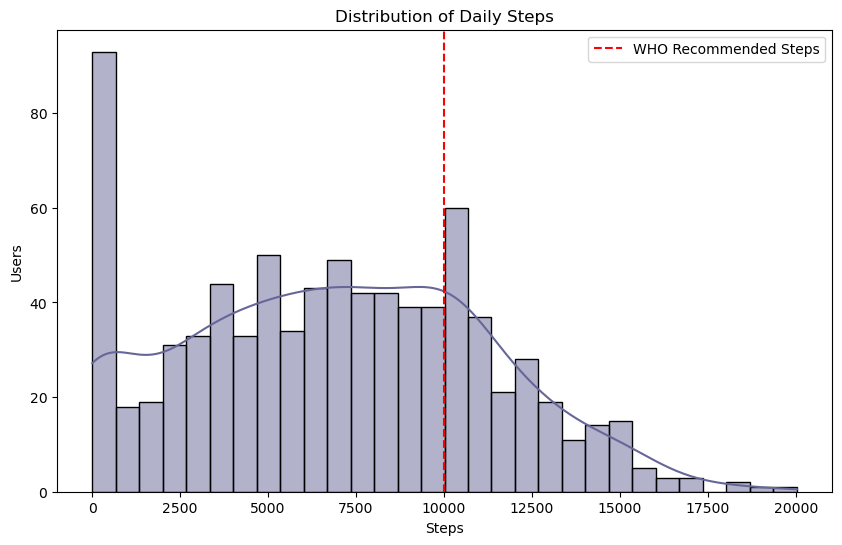

In [42]:
# Histogram with KDE for Total Steps
plt.figure(figsize=(10, 6))
sns.histplot(daily_activity_cleaned['TotalSteps'], bins=30, kde=True, color='#666699')
plt.axvline(x=10000, color='red', linestyle='--', label='WHO Recommended Steps')
plt.title('Distribution of Daily Steps')
plt.xlabel('Steps')
plt.ylabel('Users')
plt.legend()
plt.savefig('imgs/daily_steps.png')
plt.show()


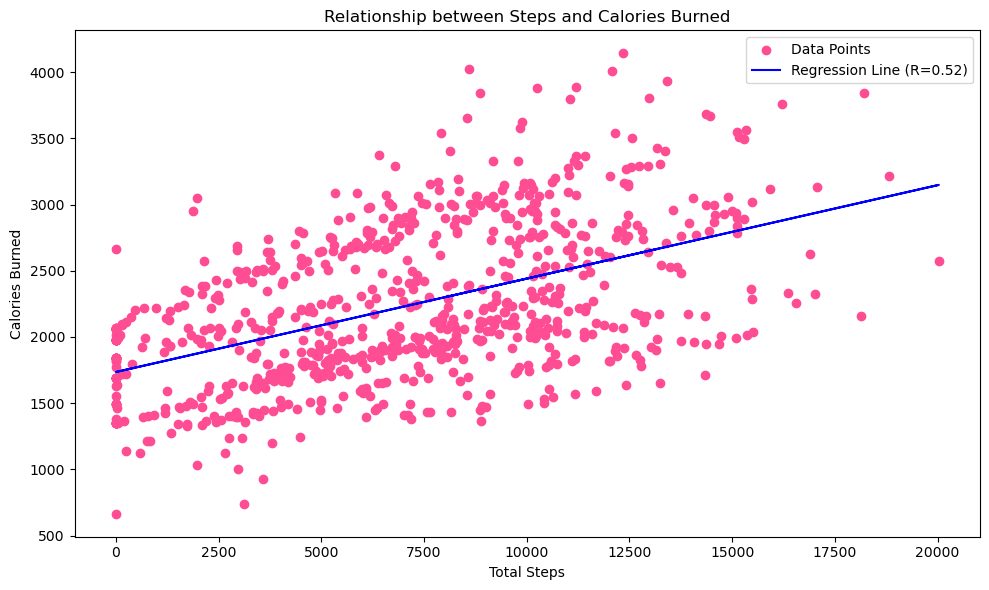

Correlation between steps and calories burned: 0.52


In [43]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(daily_activity_cleaned['TotalSteps'], daily_activity_cleaned['Calories'], color='#ff4d94', label='Data Points')

# Linear regression
x = daily_activity_cleaned['TotalSteps']
y = daily_activity_cleaned['Calories']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
regression_line = slope * x + intercept
plt.plot(x, regression_line, color='blue', label=f'Regression Line (R={r_value:.2f})')

# Labels and title
plt.xlabel('Total Steps')
plt.ylabel('Calories Burned')
plt.title('Relationship between Steps and Calories Burned')
plt.legend()
plt.tight_layout()

# Save and show the plot
plt.savefig('imgs/steps_vs_calories_with_regression.png')
plt.show()

# Correlation
correlation = x.corr(y)
print(f"Correlation between steps and calories burned: {correlation:.2f}")


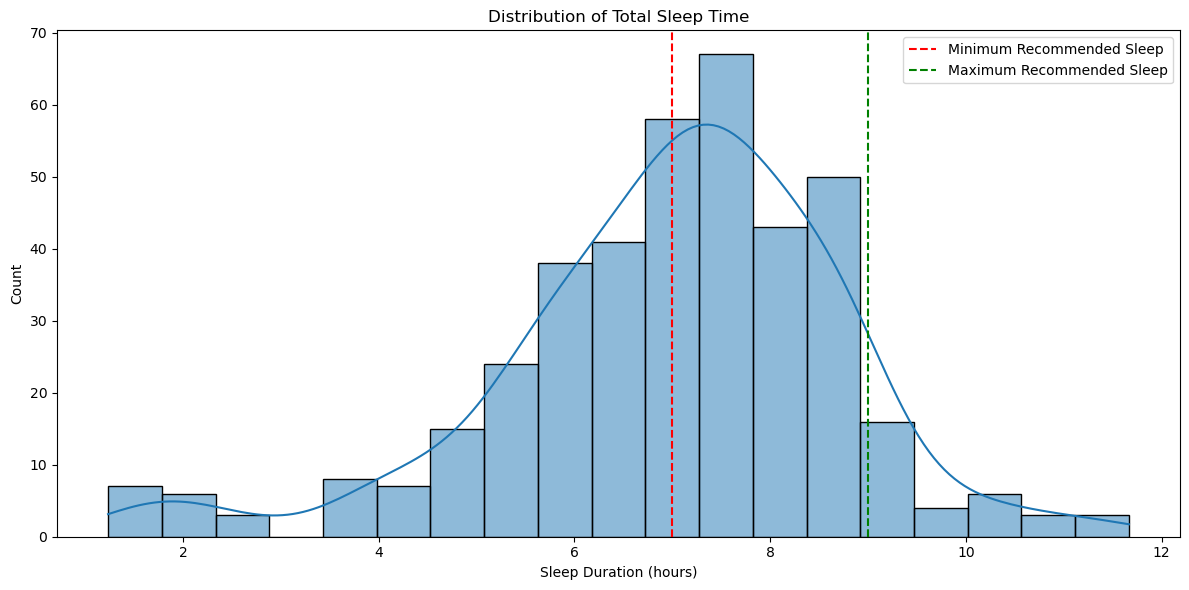

       SleepHours  SleepEfficiency
count  399.000000       399.000000
mean     6.992063         0.918136
std      1.753675         0.085572
min      1.233333         0.498361
25%      6.083333         0.912550
50%      7.200000         0.943231
75%      8.108333         0.960701
max     11.666667         0.997763


In [44]:
# Convert 'SleepDay' to datetime
sleep_data_cleaned['SleepDay'] = pd.to_datetime(sleep_data_cleaned['SleepDay'], format='%m/%d/%Y %I:%M:%S %p')

# Convert TotalMinutesAsleep to hours
sleep_data_cleaned['SleepHours'] = sleep_data_cleaned['TotalMinutesAsleep'] / 60

# Calculate sleep efficiency
sleep_data_cleaned['SleepEfficiency'] = sleep_data_cleaned['TotalMinutesAsleep'] / sleep_data_cleaned['TotalTimeInBed']

# Create a figure
plt.figure(figsize=(12, 6))

# Plot: Distribution of Total Sleep Time
sns.histplot(sleep_data_cleaned['SleepHours'], kde=True)
plt.axvline(7, color='r', linestyle='--', label='Minimum Recommended Sleep')
plt.axvline(9, color='g', linestyle='--', label='Maximum Recommended Sleep')
plt.title('Distribution of Total Sleep Time')
plt.xlabel('Sleep Duration (hours)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.savefig('imgs/sleep_analysis.png')
plt.show()

# Print summary statistics
print(sleep_data_cleaned[['SleepHours', 'SleepEfficiency']].describe())


# Averages by week

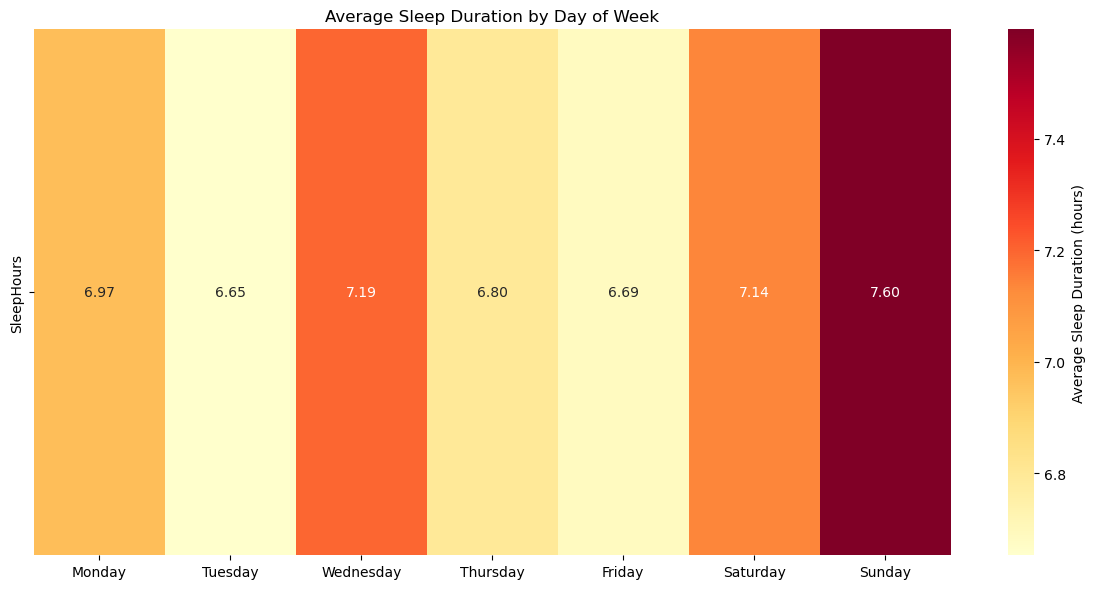

count    399.000000
mean       6.992063
std        1.753675
min        1.233333
25%        6.083333
50%        7.200000
75%        8.108333
max       11.666667
Name: SleepHours, dtype: float64

Percentage of sleep durations within WHO recommendations (7-9 hours): 48.12%


In [45]:
# Convert 'SleepDay' to datetime and extract day of week
sleep_data_cleaned['SleepDay'] = pd.to_datetime(sleep_data_cleaned['SleepDay'])
sleep_data_cleaned['DayOfWeek'] = sleep_data_cleaned['SleepDay'].dt.day_name()

# Convert TotalMinutesAsleep to hours
sleep_data_cleaned['SleepHours'] = sleep_data_cleaned['TotalMinutesAsleep'] / 60

# Calculate average sleep duration for each day of the week
sleep_by_day = sleep_data_cleaned.groupby('DayOfWeek')['SleepHours'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sleep_by_day.to_frame().T, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Average Sleep Duration (hours)'})
plt.title('Average Sleep Duration by Day of Week')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('imgs/sleep_heatmap.png')
plt.show()

# Print summary statistics
print(sleep_data_cleaned['SleepHours'].describe())

# Calculate percentage of sleep durations within WHO recommendations
who_min = 7
who_max = 9
within_who = ((sleep_data_cleaned['SleepHours'] >= who_min) & (sleep_data_cleaned['SleepHours'] <= who_max)).mean() * 100

print(f"\nPercentage of sleep durations within WHO recommendations (7-9 hours): {within_who:.2f}%")


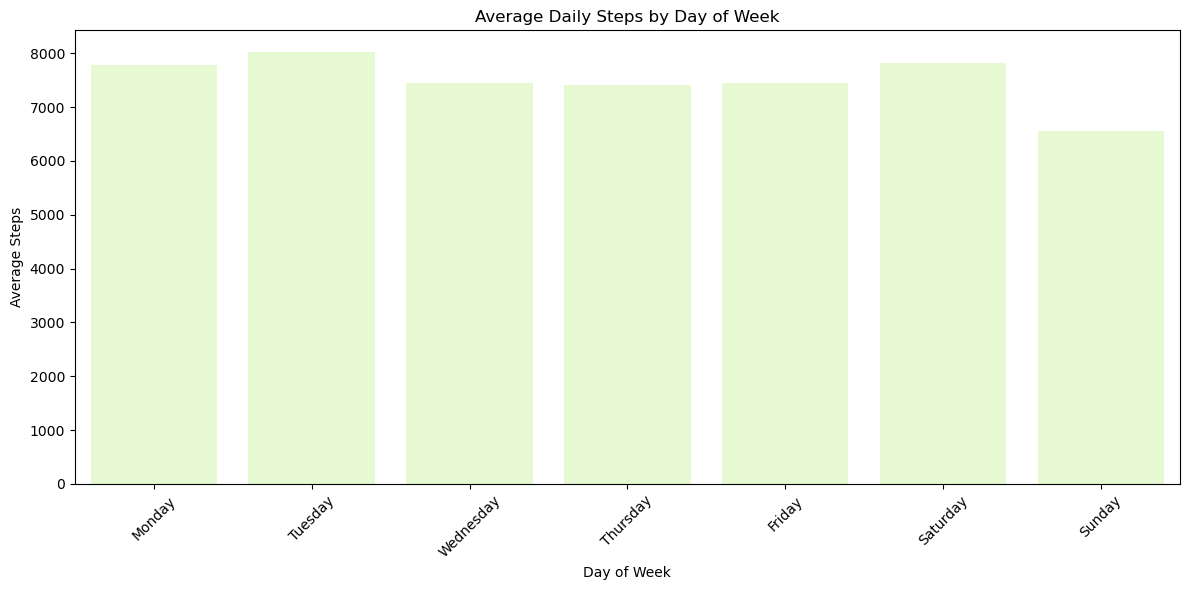

In [46]:
# Convert ActivityDay to datetime
daily_steps_cleaned['ActivityDay'] = pd.to_datetime(daily_steps_cleaned['ActivityDay'])

# Add a day of week column
daily_steps_cleaned['DayOfWeek'] = daily_steps_cleaned['ActivityDay'].dt.day_name()

# Calculate average steps for each day of the week
avg_steps = daily_steps_cleaned.groupby('DayOfWeek')['StepTotal'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_steps.index, y=avg_steps.values, color='#e6ffcc')  # Use a single hex color
plt.title('Average Daily Steps by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Steps')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('imgs/average_steps_by_day_single_color.png')
plt.show()


# Daily Data

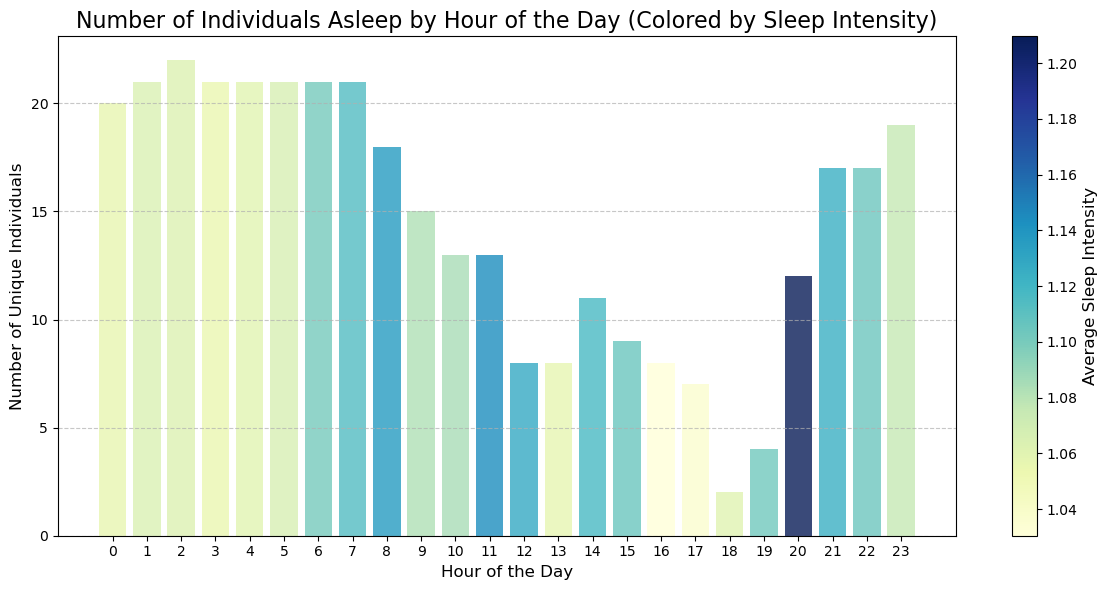

In [47]:
# Convert date column to datetime format and extract hour
minute_sleep_cleaned['date'] = pd.to_datetime(minute_sleep_cleaned['date'])
minute_sleep_cleaned['hour'] = minute_sleep_cleaned['date'].dt.hour

# Group by hour and calculate unique IDs and the average value
ids_by_hour = minute_sleep_cleaned.groupby('hour').agg(
    unique_ids=('Id', 'nunique'),
    avg_value=('value', 'mean')
).reset_index()

# Normalize the average value to map it to a color gradient
norm = plt.Normalize(ids_by_hour['avg_value'].min(), ids_by_hour['avg_value'].max())
colors = plt.cm.YlGnBu(norm(ids_by_hour['avg_value']))  # Use the 'viridis' colormap

# Plot the number of unique individuals asleep by hour with color gradient
plt.figure(figsize=(12, 6))
bars = plt.bar(ids_by_hour['hour'], ids_by_hour['unique_ids'], color=colors, alpha=0.8)

# Add a colorbar to represent the average value
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly associate the colorbar with the current axes
cbar.set_label('Average Sleep Intensity', fontsize=12)

# Add labels and title
plt.title('Number of Individuals Asleep by Hour of the Day (Colored by Sleep Intensity)', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Unique Individuals', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show the plot
plt.savefig('imgs/individuals_asleep_colored_by_intensity_fixed.png')
plt.show()


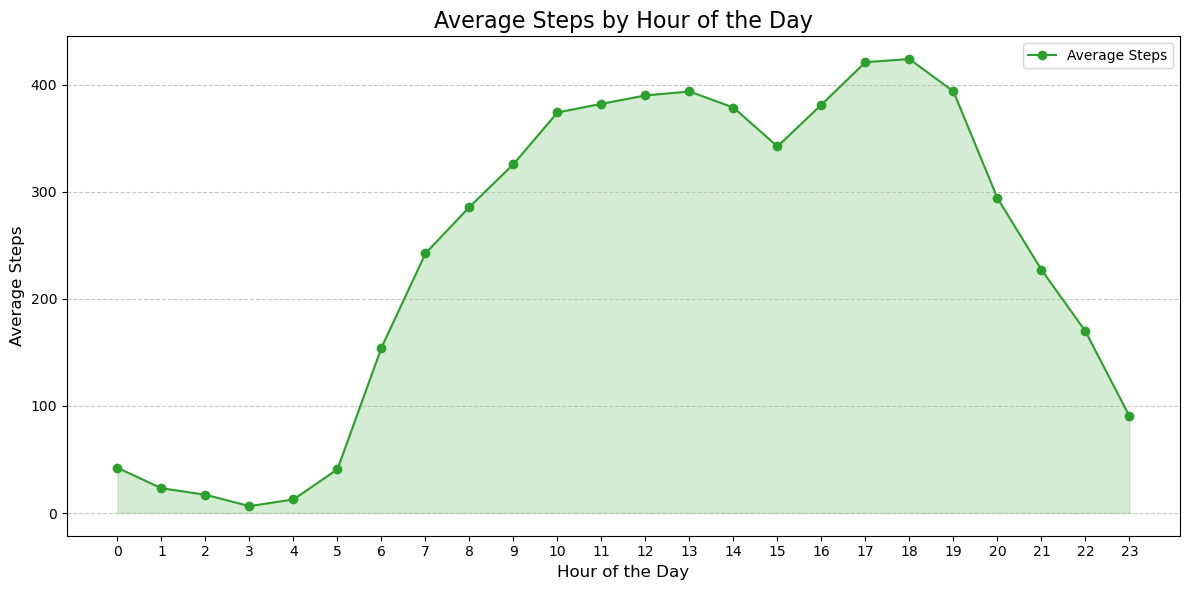

In [48]:
# Convert ActivityHour column to datetime and extract hour
hourly_steps_cleaned['ActivityHour'] = pd.to_datetime(hourly_steps_cleaned['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')
hourly_steps_cleaned['hour'] = hourly_steps_cleaned['ActivityHour'].dt.hour

# Group by hour and calculate average steps
steps_by_hour = hourly_steps_cleaned.groupby('hour')['StepTotal'].mean().reset_index()

# Plot the average steps by hour
plt.figure(figsize=(12, 6))
plt.plot(steps_by_hour['hour'], steps_by_hour['StepTotal'], marker='o', linestyle='-', color='#2ca02c', label='Average Steps')
plt.fill_between(steps_by_hour['hour'], steps_by_hour['StepTotal'], alpha=0.2, color='#2ca02c')

# Add labels and title
plt.title('Average Steps by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Steps', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Save and show the plot
plt.savefig('imgs/average_steps_by_hour.png')
plt.show()


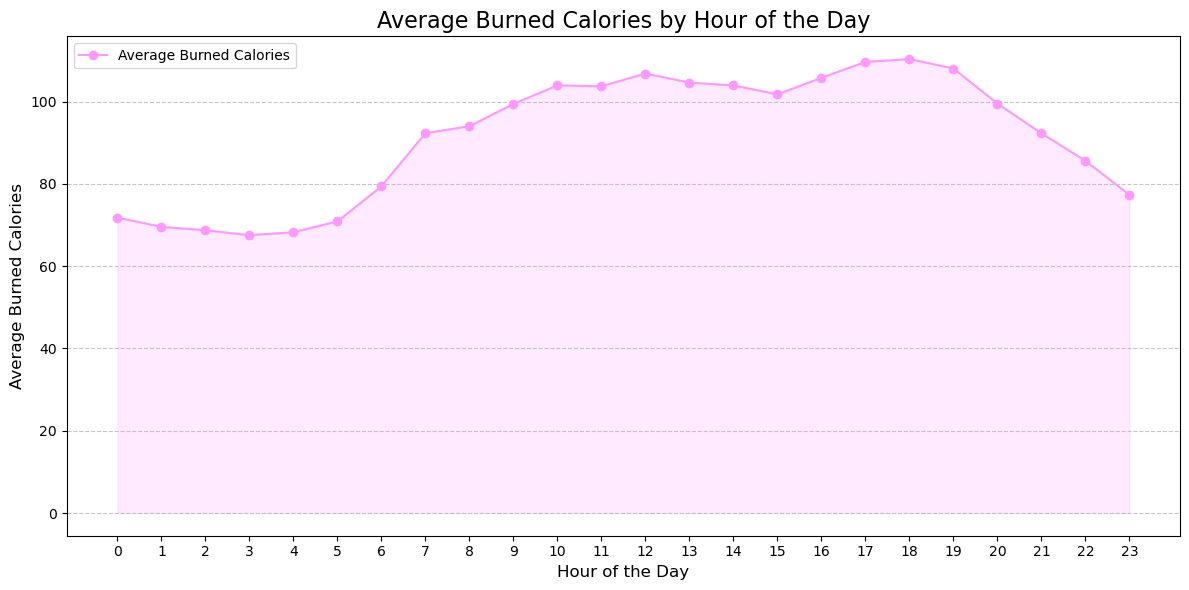

In [49]:
# Convert ActivityHour column to datetime and extract hour
hourly_calories_cleaned['ActivityHour'] = pd.to_datetime(hourly_calories_cleaned['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')
hourly_calories_cleaned['hour'] = hourly_calories_cleaned['ActivityHour'].dt.hour

# Group by hour and calculate average steps
calories_by_hour = hourly_calories_cleaned.groupby('hour')['Calories'].mean().reset_index()

# Plot the average steps by hour
plt.figure(figsize=(12, 6))
plt.plot(calories_by_hour['hour'], calories_by_hour['Calories'], marker='o', linestyle='-', color='#ff99ff', label='Average Burned Calories')
plt.fill_between(calories_by_hour['hour'], calories_by_hour['Calories'], alpha=0.2, color='#ff99ff')

# Add labels and title
plt.title('Average Burned Calories by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Burned Calories', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Save and show the plot
plt.savefig('imgs/average_calories_by_hour.png')
plt.show()


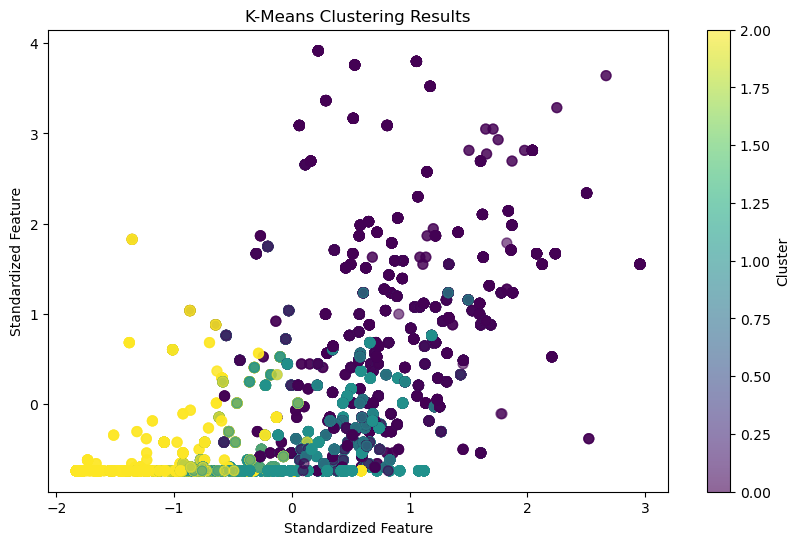

In [50]:
# Merge daily activity and sleep data
daily_activity_sleep = pd.merge(daily_activity_cleaned, sleep_data_cleaned, on='Id', how='inner')

# Select features for clustering: walking behavior and sleep patterns
features = daily_activity_sleep[[
    "TotalSteps", "VeryActiveMinutes", "FairlyActiveMinutes",
    "LightlyActiveMinutes", "TotalMinutesAsleep", "TotalTimeInBed"
]]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_scaled)

daily_activity_sleep["KMeans_Cluster"] = kmeans_labels

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(
    features_scaled[:, 0], features_scaled[:, 1],
    c=kmeans_labels, cmap='viridis', s=50, alpha=0.6
)
plt.title("K-Means Clustering Results")
plt.xlabel("Standardized Feature")
plt.ylabel("Standardized Feature")
plt.colorbar(label="Cluster")
plt.savefig('imgs/cluster.png')
plt.show()